## How to locate lane pixels

In order to locate lane pixels, we employ couple of advanced methods here. One new feature that's introduced is the Line object. We use it to keep track of previous results.

### 1. Slide Window Search

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [20]:
"""
Draw a 3-degree polynomial line on an image
"""
def draw_polyline(img, fit):
    y = np.linspace(0, img.shape[0]-1, img.shape[0])
    x = fit[0] * y**2 + fit[1] * y + fit[2]
    pts = np.array([np.transpose(np.vstack([x, y]))])
    cv2.polylines(img, np.int_(pts), isClosed=False, color=(255,255,0), thickness=3)
    return img

In [19]:
"""
Sliding window search method. It's used to locate lane pixels from scratch, given no previous information.
Input: a binary image with birds' eye view.
Ouput: fitted left/right lane lines, a diagnosis image.
"""
def sliding_win_search(binary_warped, nwindows=9, margin=100, minpix=50):
    # A diagnosis image
    diag_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Get the histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(diag_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3) 
        cv2.rectangle(diag_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Highlight lane pixels and draw fit polynomials
    diag_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    diag_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    draw_polyline(diag_img, left_fit)
    draw_polyline(diag_img, right_fit)
    
    return left_fit, right_fit, diag_img

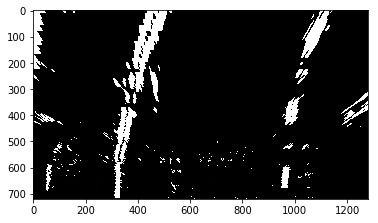

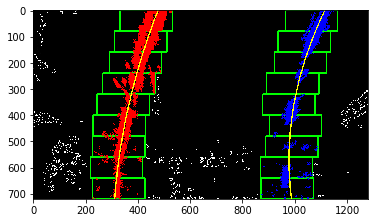

In [21]:
img = mpimg.imread('warped.jpg')
plt.imshow(img, cmap='gray')
plt.show()

left_fit, right_fit, diag_img = sliding_win_search(img)
plt.imshow(diag_img)
plt.show()

### 2. Polynomial ROI search

If we keep track of the location of previous lane line, we can search around those lane lines. 

In [37]:
"""
Draw search region (Region of Interest) on an image
"""
def draw_roi(img, fit, margin):
    window_img = np.zeros_like(img)
    
    # Generate x and y values for plotting
    y = np.linspace(0, img.shape[0]-1, img.shape[0])
    x = fit[0] * y**2 + fit[1] * y + fit[2]
    
    line_window1 = np.array([np.transpose(np.vstack([x-margin, y]))])
    line_window2 = np.array([np.flipud(np.transpose(np.vstack([x+margin, y])))])
    line_pts = np.hstack((line_window1, line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([line_pts]), (0,255, 0))
    result = cv2.addWeighted(img, 1, window_img, 0.3, 0)
    return result

In [38]:
"""
Search lane pixels within a polynomial ROI given the previous left and right lane polynomial function.
Input: a binary image from birds' eye view, left lane and right lane polynomial function.
Output: fitted left/right lane lines, a diagnosis image.
"""
def search_roi(binary_warped, left_fit, right_fit, margin=100):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    left_center = left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2]
    left_lane_inds = ((nonzerox > (left_center - margin)) & (nonzerox < (left_center + margin))) 
    right_center = right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2]
    right_lane_inds = ((nonzerox > (right_center - margin)) & (nonzerox < (right_center + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    
    #------------- VISUALIZE THE OUTPUT ------------------

    # Create an image to draw on and an image to show the selection window
    diag_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Color in left and right line pixels
    diag_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    diag_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Illustrate the search window area
    diag_img = draw_roi(diag_img, left_fit, margin)
    diag_img = draw_roi(diag_img, right_fit, margin)
    draw_polyline(diag_img, left_fit)
    draw_polyline(diag_img, right_fit)
    return left_fit, right_fit, diag_img

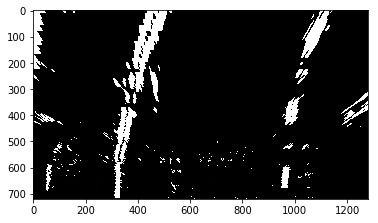

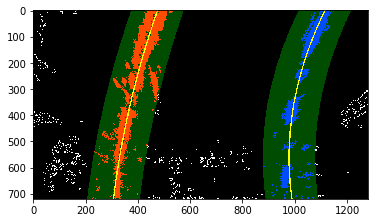

In [39]:
img = mpimg.imread('warped.jpg')
plt.imshow(img, cmap='gray')
plt.show()

left_fit, right_fit, diag_img = search_roi(img, left_fit, right_fit)
plt.imshow(diag_img)
plt.show()

### 3. Line Object

Build a Line object to keep track of important information. This is very important, since last n iteration contains rich information that we want to utilize.

In [41]:
def cal_curvature(left_fitx, right_fitx, ploty):
    ym_per_pix = 30/720
    xm_per_pix = 3.7/1100

    y_eval = np.max(ploty)

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

In [ ]:
# Define a class to receive the characteristics of each line detection
class Line():
    n = 5 # Number of iterations that's to be averaged
    
    def __init__(self):
        self.img_w = None
        self.img_h = None
        
        # was the line detected in the last iteration?
        self.detected = False  
        
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])] 
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
         
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
    """
    Find lane pixels given a binary warped image.
    Input: a binary image from birds' eye view.
    Output: left and right lane in polynomial function and a diagnosis image
    """
    def find_lane(self, binary_warped):
        self.img_w = binary_warped.shape[1]
        self.img_h = binary_warped.shape[0]
        
        if (self.detected):
            left_fit, right_fit, diag_img = search_roi(binary_warped)
        else:
            left_fit, right_fit, diag_img = sliding_win_search(binary_warped)
     
    """
    Sanity check on new found lines.
    Input: left and right lane.
    Output: True or False means pass or not.
    """
    def sanity_check(self, left_fit, right_fit):
        y = np.linspace(0, self.img_h-1, self.img_h)
        left_fitx = left_fit[0] * y**2 + left_fit[1] * y + left_fit[2]
        right_fitx = right_fit[0] * y**2 + right_fit[1] * y + right_fit[2]
        
        # 1. Check if they have similar curvature
        curv_dev = 5 # variance, 5 times
        left_curverad, right_curverad = cal_curvature(left_fitx, right_fitx, y)
        ratio = left_curverad / right_curverad 
        if (ratio >= curv_dev | ratio <= 1./curv_dev):
            return false
        
        # 2. Check lines are seperated by right distance
        dist_dev = 20
        curr_leftx = curr_leftx[-1]
        curr_rightx = curr_rightx[-1]
        prev_dist = self.best_rightx - self.best_leftx
        curr_dist = curr_rightx - curr_leftx
        if (np.abs(curr_dist - prev_dist) > dist_dev):
            return False
        
        # 3. Check if lines are roughly paralell
        lines_dev = 10
        dist = right_fitx - left_fitx
        dev = np.std(dist)
        if (dev >= 10):
            return False
        
        return True

### 4. Algorithm

The algorithm is:
If line was not detected in the last 

TypeError: expected non-empty vector for x